<a href="https://colab.research.google.com/github/tada20001/NLP_2023/blob/main/CH18_04_TFBertForSequenceClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 28.2 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import urllib.request
from sklearn import preprocessing
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### 1. 데이터 로드 및 전처리
-----------------------
카카오 브레인에서 2020년에 공개한 데이터셋. 기계번역용으로 NLI 데이터셋

* NLI는 한쌍의 문장, 전제와 가설을 받고, 그 관계를 entailment(관련됨), contradiction(모순), neutral(중립) 중 하나로 분류

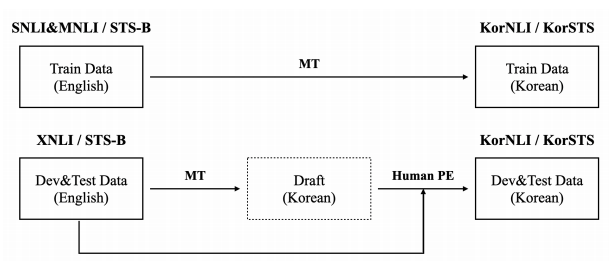

In [3]:
# 훈련데이터 다운로드드
urllib.request.urlretrieve("https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorNLI/multinli.train.ko.tsv", filename="multinli.train.ko.tsv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorNLI/snli_1.0_train.ko.tsv", filename="snli_1.0_train.ko.tsv")
     

('snli_1.0_train.ko.tsv', <http.client.HTTPMessage at 0x7f00f004a610>)

In [4]:
# 검증 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorNLI/xnli.dev.ko.tsv", filename="xnli.dev.ko.tsv")

('xnli.dev.ko.tsv', <http.client.HTTPMessage at 0x7f00f004a6a0>)

In [5]:
# 테스트 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorNLI/xnli.test.ko.tsv", filename="xnli.test.ko.tsv")

('xnli.test.ko.tsv', <http.client.HTTPMessage at 0x7f00f004a580>)

In [6]:
train_snli = pd.read_csv("snli_1.0_train.ko.tsv", sep='\t', quoting=3)
train_xnli = pd.read_csv("multinli.train.ko.tsv", sep='\t', quoting=3)
val_data = pd.read_csv("xnli.dev.ko.tsv", sep='\t', quoting=3)
test_data = pd.read_csv("xnli.test.ko.tsv", sep='\t', quoting=3)

In [7]:
train_snli.shape, val_data.shape, test_data.shape

((550152, 3), (2490, 3), (5010, 3))

In [8]:
train_snli.tail()

,sentence1,sentence2,gold_label
550147,네 명의 더러운 맨발의 아이들.,4명의 아이들이 '가장 깨끗한 발'로 상을 받았다,contradiction
550148,네 명의 더러운 맨발의 아이들.,네 명의 노숙자 아이들이 신발을 도둑맞아서 그들의 발이 더러워졌다.,neutral
550149,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,바디슈트를 입은 남자가 서핑 대회에 참가하고 있다.,neutral
550150,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,비즈니스 슈트를 입은 남자가 이사회로 향하고 있다.,contradiction
550151,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,아름다운 푸른 물 위에는 바디슈트를 입은 남자가 서핑을 하고 있다.,entailment


In [9]:
train_xnli.tail()

,sentence1,sentence2,gold_label
392697,"분명히, 캘리포니아는 더 잘 할 수 있고, 더 잘해야 한다.",캘리포니아는 더 잘할 수 없다.,contradiction
392698,"한때 유럽에서 가장 아름다운 거리로 여겨졌는데, 이는 원래의 많은 건물들이 교체되었...",그래서 원래의 많은 건물들이 편의점으로 대체되었다.,neutral
392699,하우스보트는 영국 라지의 전성기의 아름답게 보존된 전통이다.,하우스보트의 전통은 영국 라지가 여전히 강해지는 동안 시작되었다.,entailment
392700,사망 기사는 그의 평론가의 신디케이트 TV 쇼에서 동료 검토 자 Roger Eber...,부고문은 아름다웠고 연예계에서의 그의 업적에 대해 현물로 쓰여졌다.,neutral
392701,"내가 해야 한다는 걸 알거나, 아니면 누가 하라고 하는 것보다 그녀를 밀고하는 것에...",남편이 요즘 너무 과로해서 이 근처에서 많은 일을 부탁할 용기가 나지 않는다.,neutral


In [10]:
# 위의 두 데이터를 결합하여 섞기
train_data = pd.concat([train_snli, train_xnli])
train_data = train_data.sample(frac=1)

In [11]:
train_data.tail()

,sentence1,sentence2,gold_label
240782,하얀 옷을 입은 여자가 길을 걷고 있다.,여자가 걷고 있다.,entailment
501994,서로 마주보고 있는 두 소녀는 빨간색과 검은색 셔츠를 입은 두개골 얼굴 가방을 가지...,이 사진에는 두 명의 소녀가 있습니다.,entailment
194251,두 사람이 흙길에서 흙자전거를 타다가 모퉁이를 돌고 있다.,두 사람이 오물 자전거를 탄다.,entailment
520532,많은 사람들이 옥스퍼드 서커스 역 주변에 모였다.,한 소년이 공을 가지고 놀고 있다,contradiction
476757,반팔 줄무늬 셔츠를 입고 녹색 쇼핑백을 든 여성이 야외 시장에서 생선을 검사하는 동...,한 여성이 야외 시장에서 쇼핑을 한다.,entailment


In [12]:
val_data.tail()

,sentence1,sentence2,gold_label
2485,피스티는 피즐처럼 중간 영어의 피스틴으로 시작되어 방귀를 뀌기 위해 주먹을 쥐었다.,Fiesty는 100년 동안 존재해 왔다.,neutral
2486,피스티는 피즐처럼 중간 영어의 피스틴으로 시작되어 방귀를 뀌기 위해 주먹을 쥐었다.,Fiesty는 주먹질과는 무관하다.,contradiction
2487,"진술이 더 나은 반면, 대답은 완성의 정신적 그림을 준다.",진술은 더 자세한 내용을 알려준다.,neutral
2488,"진술이 더 나은 반면, 대답은 완성의 정신적 그림을 준다.",진술이 더 나은 것은 아니다.,contradiction
2489,"진술이 더 나은 반면, 대답은 완성의 정신적 그림을 준다.",진술이 더 좋다.,entailment


In [13]:
test_data.tail()

,sentence1,sentence2,gold_label
5005,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson은 뼈와 스콘이 같은 소리를 내는 방식으로 말하면 안 된다.,entailment
5006,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson이 스콘과 뼈라는 단어에 운율을 맞추는 편이 나을 것이다.,contradiction
5007,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 공정한 가격이다.,neutral
5008,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 달러당 4천 단어다.,contradiction
5009,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.","25달러짜리 20만 단어 소설은 달러당 8,000 단어다.",entailment


In [17]:
# null 값  및 중복 제거 
def dropna_and_duplicates(df):
  df = df.dropna(how='any')
  df = df.drop_duplicates()
  df = df.reset_index(drop=True)
  return df

In [18]:
train_data = dropna_and_duplicates(train_data)
val_data = dropna_and_duplicates(val_data)
test_data = dropna_and_duplicates(test_data)

In [19]:
train_data.tail()

,sentence1,sentence2,gold_label
941809,하얀 옷을 입은 여자가 길을 걷고 있다.,여자가 걷고 있다.,entailment
941810,서로 마주보고 있는 두 소녀는 빨간색과 검은색 셔츠를 입은 두개골 얼굴 가방을 가지...,이 사진에는 두 명의 소녀가 있습니다.,entailment
941811,두 사람이 흙길에서 흙자전거를 타다가 모퉁이를 돌고 있다.,두 사람이 오물 자전거를 탄다.,entailment
941812,많은 사람들이 옥스퍼드 서커스 역 주변에 모였다.,한 소년이 공을 가지고 놀고 있다,contradiction
941813,반팔 줄무늬 셔츠를 입고 녹색 쇼핑백을 든 여성이 야외 시장에서 생선을 검사하는 동...,한 여성이 야외 시장에서 쇼핑을 한다.,entailment


In [20]:
train_data.shape

(941814, 3)

In [21]:
val_data.shape, test_data.shape

((2490, 3), (5010, 3))

### 2. 토큰화 및 패딩

In [22]:
# 토크나이저 로딩
tokenizer = BertTokenizer.from_pretrained('klue/bert-base')

In [23]:
max_seq_len = 128

In [26]:
from IPython.utils import encoding
def convert_examples_to_features(sent_list1, sent_list2, max_seq_len, tokenizer):
  input_ids, attention_masks, token_type_ids = [], [], []

  for sent1, sent2 in tqdm(zip(sent_list1, sent_list2), total=len(sent_list1)):
    encoding_result = tokenizer.encode_plus(sent1, sent2, max_length=max_seq_len, pad_to_max_length=True)  # input_ids, token_type_ids, attention_mask 출력

    input_ids.append(encoding_result['input_ids'])
    attention_masks.append(encoding_result['attention_mask'])
    token_type_ids.append(encoding_result['token_type_ids'])

  input_ids = np.array(input_ids, dtype=int)
  attention_masks = np.array(attention_masks, dtype=int)
  token_type_ids = np.array(token_type_ids, dtype=int)

  return (input_ids, attention_masks, token_type_ids)

In [27]:
X_train = convert_examples_to_features(train_data['sentence1'], train_data['sentence2'], max_seq_len, tokenizer)

  0%|          | 1562/941814 [00:01<12:14, 1279.34it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
  0%|          | 4521/941814 [00:04<21:20, 731.91it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have b

In [28]:
X_train[0]

array([[    2,  9378, 10727, ...,     0,     0,     0],
       [    2,  9738,  2069, ...,     0,     0,     0],
       [    2, 15331,  3113, ...,     0,     0,     0],
       ...,
       [    2,   864,  3611, ...,     0,     0,     0],
       [    2,  1039,  2073, ...,     0,     0,     0],
       [    2,  1121,  2892, ...,     0,     0,     0]])

In [29]:
# X_trian[0] 데이터 확인
input_id = X_train[0][0]
attention_mask = X_train[1][0]
token_type_id = X_train[2][0]

print('단어에 대한 정수 인코딩 :', input_id)
print('어텐션 마스크 : ', attention_mask)
print('세그먼트 인코딩 : ', token_type_id)
print('인코딩 길이 :', len(input_id))
print('정수 인코딩 복원: ', tokenizer.decode(input_id))

단어에 대한 정수 인코딩 : [    2  9378 10727  2522  8802  2138  1511  2073  3883  2116 17378    16
  1495  3409  7860    16 29701  1891   712  2138  4919    18     3  3821
  2259 26374  2138  1511  2088 13309  2138  1059  2088  1513  2359  2062
    18     3     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
어텐션 마스크 :  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [30]:
X_val = convert_examples_to_features(val_data['sentence1'], val_data['sentence2'], max_seq_len, tokenizer)
X_test = convert_examples_to_features(test_data['sentence1'], test_data['sentence2'], max_seq_len, tokenizer)

  0%|          | 0/2490 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 5010/5010 [00:09<00:00, 523.78it/s]


In [31]:
# 라벨 데이터 만들기
train_label = train_data['gold_label'].to_list()
val_label = val_data['gold_label'].to_list()
test_label = test_data['gold_label'].to_list()

In [32]:
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(train_label)

y_train = idx_encode.transform(train_label)
y_val = idx_encode.transform(val_label)
y_test = idx_encode.transform(test_label)

In [33]:
label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
idx_label = {value : key for key, value in label_idx.items()}
print(label_idx)
print(idx_label)

{'contradiction': 0, 'entailment': 1, 'neutral': 2}
{0: 'contradiction', 1: 'entailment', 2: 'neutral'}


### 4. 모델 설계

In [34]:
from transformers import TFBertForSequenceClassification

In [38]:
# TPU 작동 설정
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [39]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [40]:
with strategy.scope():
  model = TFBertForSequenceClassification.from_pretrained('klue/bert-base', num_labels=3, from_pt=True)
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 5. 학습

In [42]:
early_stopping = EarlyStopping(
    monitor='val_acurracy',
    min_delta=0.001,
    patience=2)

model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/2
29432/29432 [==============================] - ETA: 0s - loss: 0.5338 - accuracy: 0.7877

29432/29432 [==============================] - 2610s 85ms/step - loss: 0.5338 - accuracy: 0.7877 - val_loss: 0.5554 - val_accuracy: 0.7719
Epoch 2/2
29432/29432 [==============================] - ETA: 0s - loss: 0.4362 - accuracy: 0.8322

29432/29432 [==============================] - 2391s 81ms/step - loss: 0.4362 - accuracy: 0.8322 - val_loss: 0.5423 - val_accuracy: 0.7811


In [43]:
print('\n 테스트 정확도 : %.4f' % (model.evaluate(X_test, y_test, batch_size=1024)[1]))

5/5 [==============================] - 15s 2s/step - loss: 0.5289 - accuracy: 0.7928

 테스트 정확도 : 0.7928
